In [8]:
import matplotlib.pyplot as plt
import torch
from torch import nn, optim, autograd
from torch.nn import functional as F

import numpy as np
import scipy.spatial
import math
import os
import pyemma as pe
from mpl_toolkits import mplot3d


In [9]:
Dx = 3
N =10000
kBT = 20
repeat_times = 100

aa = [-1, -1, -6.5, 0.7]
bb = [0, 0, 11, 0.6]
cc = [-10, -10, -6.5, 0.7]
AA = [-200, -100, -170, 15]
XX = [1, 0, -0.5, -1]
YY = [0, 0.5, 1.5, 1]
sigma = 0.05
os.makedirs('./Data', exist_ok=True)
USE_GPU = torch.cuda.is_available()

In [10]:
def get_V(px):
    px = np.array(px)
    ee = 0
    if np.size(px.shape) == 2:
        for j in range(4):
            ee = ee + AA[j] * np.exp(aa[j] * (px[:, 0] - XX[j]) ** 2 +
                                              bb[j] * (px[:, 0] - XX[j]) * (px[:, 1] - YY[j]) +
                                              cc[j] * (px[:, 1] - YY[j]) ** 2)
        ee += 9 * np.sin(2 * 5 * np.pi * px[:, 0]) * np.sin(2 * 5 * np.pi * px[:, 1])
        for i in range(2, Dx):
            ee += px[:, i] ** 2 / 2 / sigma ** 2
    else:
        for j in range(4):
            ee = ee + AA[j] * np.exp(aa[j] * (px[0] - XX[j]) ** 2 +
                                              bb[j] * (px[0] - XX[j]) * (px[1] - YY[j]) +
                                              cc[j] * (px[1] - YY[j]) ** 2)
        ee += 9 * np.sin(2 * 5 * np.pi * px[0]) * np.sin(2 * 5 * np.pi * px[1])
        for i in range(2, Dx):
            ee += px[i] ** 2 / 2 / sigma ** 2
    return ee

In [11]:
def get_grad(px):
    px = np.array(px)
    gg = np.zeros(shape=(Dx,), dtype=np.float64)
    for j in range(4):
        ee = AA[j] * np.exp(aa[j] * (px[0] - XX[j]) ** 2 +
                                     bb[j] * (px[0] - XX[j]) * (px[1] - YY[j]) +
                                     cc[j] * (px[1] - YY[j]) ** 2)
        gg[0] = gg[0] + (2 * aa[j] * (px[0] - XX[j]) +
                             bb[j] * (px[1] - YY[j])) * ee
        gg[1] = gg[1] + (bb[j] * (px[0] - XX[j]) +
                             2 * cc[j] * (px[1] - YY[j])) * ee
    gg[0] += 9 * 2 * 5 * np.pi * np.cos(2 * 5 * np.pi * px[0]) * np.sin(2 * 5 * np.pi * px[1])
    gg[1] += 9 * 2 * 5 * np.pi * np.sin(2 * 5 * np.pi * px[0]) * np.cos(2 * 5 * np.pi * px[1])
    for i in range(2, Dx):
        gg[i] = px[i] / sigma ** 2
    return gg

In [111]:
def sim_data(kBT, dt, D_size, firstsave=1000, t_sep=100):
    D = []
    px = np.zeros((Dx,))
    id_ = 0
    i = 0
    while True:
        px = px - dt * get_grad(px) + np.sqrt(2 * kBT * dt) * np.random.normal(size=(Dx,))
        if i >= firstsave and i % t_sep == 0 and 1 >= px[0] >= -1.5 \
                and 2 >= px[1] >= -0.5:
            D.append(px)
            id_ += 1
            if id_ >= D_size:
                break
        i += 1
    data = np.zeros((D_size, 1 + Dx))
    data[:, 1:] = np.array(D)
    data[:, 0] = get_V(D)
    print('generating data finished!')
    return data

In [70]:
data_ori = []
for i in range(repeat_times):
    data_ori_t = sim_data(kBT = kBT, dt = 1e-5, D_size = N)
    data_ori.extend(data_ori_t)
print(np.shape(data_ori))

KeyboardInterrupt: 

In [1]:
np.savetxt('Data/data_'+str(N)+'_'+str(kBT)+'_'+str(repeat_times),data_ori)

NameError: name 'np' is not defined

In [12]:
data_ori1 = np.loadtxt('Data/data_'+str(N)+'_'+str(kBT)+'_'+str(repeat_times)).reshape(-1,3)

In [13]:
print(np.shape(data_ori1))

(1000000, 3)


In [224]:
data_ori2 = 0.5*np.random.normal(loc = 1.0, scale = 1.0, size = (np.shape(data_ori1)[0],1) ) + 0.5*np.random.normal(loc = 3.0, scale = 1.0, size = (np.shape(data_ori1)[0],1) )

In [225]:
data_ori = np.concatenate((data_ori1, data_ori2), axis = 1)

In [226]:
print(np.shape(data_ori))

(1000000, 4)


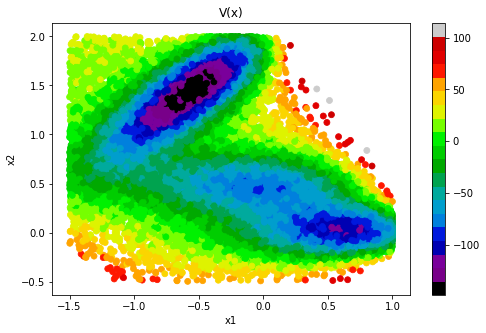

In [227]:
fig, ax = plt.subplots(figsize=(8, 5))
pic1 = ax.scatter(data_ori[:, 1], data_ori[:, 2], marker='o',lw = 0.75,c=data_ori[:,0], cmap = plt.cm.get_cmap('nipy_spectral', 20))
ax.set_title('V(x)')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
fig.colorbar(pic1)

In [7]:
pe.plots.plot_free_energy(data_ori[:,1],data_ori[:,2])

NameError: name 'data_ori' is not defined

In [229]:
X0 = torch.from_numpy(data_ori[:20000, 1:]).float()
print(X0.size())

X1 = torch.from_numpy(data_ori[100:20100, 1:]).float()
Dy = 2
Y0 = X0[:,:-1].reshape(-1,Dy)
Y1 = X1[:,:-1].reshape(-1,Dy)
print(Y0.size())

torch.Size([20000, 3])
torch.Size([20000, 2])


In [230]:
train_batch_size = 128

train_loader = torch.utils.data.DataLoader(
    torch.cat([X0, X1, Y1], 1), batch_size = train_batch_size, shuffle = True)

In [231]:
Dr = 2


R_net = nn.Sequential(
    nn.Linear(Dx, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, Dr)
    )

T_net = nn.Sequential(
    nn.Linear(2*Dr + Dy, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 1)
    )

Tx_net = nn.Sequential(
    nn.Linear(Dx + Dr + Dy, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 1)
    )

In [232]:
def learn_max(data_X0,data_X1,data_iX1,data_Y1, data_iY1, R_net, T_net , Tx_net, optimizer_max):


    if USE_GPU:
        data_X0 = data_X0.cuda()
        data_X1 = data_X1.cuda()
        data_iX1 = data_iX1.cuda()
        data_Y1 = data_Y1.cuda()
        data_iY1 = data_iY1.cuda()
 
     
    R0 = R_net(data_X0)
    R1 = R_net(data_X1)
    iR1 = R_net(data_iX1)
        
    Tx_J = Tx_net(torch.cat([data_X0, R1, data_Y1], 1))
    Tx_I = Tx_net(torch.cat([data_X0, iR1, data_iY1], 1))
    T_J = T_net(torch.cat([R0, R1, data_Y1], 1))
    T_I = T_net(torch.cat([R0, iR1, data_iY1], 1))
    
    loss = 0.
    T_loss = -T_J.mean() + torch.logsumexp(T_I, 0) + Tx_J.mean() - torch.logsumexp(Tx_I, 0) 
    loss += T_loss

     
    optimizer_max.zero_grad()
    loss.backward()
    optimizer_max.step()



    return -T_loss.item()

In [233]:
def learn_min(data_X0,data_X1,data_iX1,data_Y1, data_iY1, R_net, T_net , Tx_net, optimizer_min):


    if USE_GPU:
        data_X0 = data_X0.cuda()
        data_X1 = data_X1.cuda()
        data_iX1 = data_iX1.cuda()
        data_Y1 = data_Y1.cuda()
        data_iY1 = data_iY1.cuda()
 
     
    R0 = R_net(data_X0)
    R1 = R_net(data_X1)
    iR1 = R_net(data_iX1)
        
    Tx_J = Tx_net(torch.cat([data_X0, R1, data_Y1], 1))
    Tx_I = Tx_net(torch.cat([data_X0, iR1, data_iY1], 1))
    
    loss = 0.
    Tx_loss = -Tx_J.mean() + torch.logsumexp(Tx_I, 0)
    loss += Tx_loss

     
    optimizer_min.zero_grad()
    loss.backward()
    optimizer_min.step()




In [ ]:
lr = 1e-5
optimizer_max = optim.Adam(list(R_net.parameters()) + list(T_net.parameters()), lr=lr)
scheduler_max = torch.optim.lr_scheduler.StepLR(optimizer_max, step_size=25, gamma=0.1)

optimizer_min = optim.Adam(list(Tx_net.parameters()), lr=lr)
scheduler_min = torch.optim.lr_scheduler.StepLR(optimizer_min, step_size=25, gamma=0.1)

n_epochs = 400
train_data_size = len(train_loader.dataset)
for epoch in range(1, n_epochs + 1):
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):

        actual_size = len(data)
        data = data
        data_X0 = data[:, :Dx]
        data_X1 = data[:, Dx:2*Dx]
        data_Y1 = data[:, 2*Dx:]

        
        #rand_ind = np.random.choice(train_data_size, actual_size, replace=False)
        #data_iX1 = train_loader.dataset[rand_ind, Dx:2*Dx].to(device)
        data_iX1 = data_X1[torch.randperm(actual_size)]
        data_iY1 = data_Y1[torch.randperm(actual_size)]
        
        learn_min(data_X0, data_X1, data_iX1, data_Y1, data_iY1, R_net, T_net , Tx_net, optimizer_min)
        T_loss = learn_max(data_X0, data_X1, data_iX1, data_Y1, data_iY1, R_net, T_net , Tx_net, optimizer_max)
        
        

        train_loss += T_loss * len(data)
        


    train_loss /= len(train_loader.dataset)
    
    if epoch % 1 == 0:
        print('Train Epoch: {} ===> Train set loss: {:.4f}'.format(epoch, train_loss))
        
    scheduler_min.step()
    scheduler_max.step()

    

Train Epoch: 1 ===> Train set loss: -0.0004
Train Epoch: 2 ===> Train set loss: -0.0015
Train Epoch: 3 ===> Train set loss: -0.0022
Train Epoch: 4 ===> Train set loss: -0.0024
Train Epoch: 5 ===> Train set loss: -0.0010
Train Epoch: 6 ===> Train set loss: 0.0045
Train Epoch: 7 ===> Train set loss: 0.0172
Train Epoch: 8 ===> Train set loss: 0.0350
Train Epoch: 9 ===> Train set loss: 0.0600
Train Epoch: 10 ===> Train set loss: 0.0883
Train Epoch: 11 ===> Train set loss: 0.1171
Train Epoch: 12 ===> Train set loss: 0.1419
Train Epoch: 13 ===> Train set loss: 0.1677
Train Epoch: 14 ===> Train set loss: 0.1932
Train Epoch: 15 ===> Train set loss: 0.2155
Train Epoch: 16 ===> Train set loss: 0.2225
Train Epoch: 17 ===> Train set loss: 0.2404
Train Epoch: 18 ===> Train set loss: 0.2459
Train Epoch: 19 ===> Train set loss: 0.2355
Train Epoch: 20 ===> Train set loss: 0.2360
Train Epoch: 21 ===> Train set loss: 0.2261
Train Epoch: 22 ===> Train set loss: 0.2291
Train Epoch: 23 ===> Train set loss:

Train Epoch: 186 ===> Train set loss: 0.2057
Train Epoch: 187 ===> Train set loss: 0.1981
Train Epoch: 188 ===> Train set loss: 0.2054
Train Epoch: 189 ===> Train set loss: 0.2024
Train Epoch: 190 ===> Train set loss: 0.2089
Train Epoch: 191 ===> Train set loss: 0.2100
Train Epoch: 192 ===> Train set loss: 0.2022
Train Epoch: 193 ===> Train set loss: 0.2072
Train Epoch: 194 ===> Train set loss: 0.2082
Train Epoch: 195 ===> Train set loss: 0.2147
Train Epoch: 196 ===> Train set loss: 0.2055
Train Epoch: 197 ===> Train set loss: 0.1992
Train Epoch: 198 ===> Train set loss: 0.1953
Train Epoch: 199 ===> Train set loss: 0.2130
Train Epoch: 200 ===> Train set loss: 0.2100
Train Epoch: 201 ===> Train set loss: 0.2034
Train Epoch: 202 ===> Train set loss: 0.2092
Train Epoch: 203 ===> Train set loss: 0.2136
Train Epoch: 204 ===> Train set loss: 0.2094
Train Epoch: 205 ===> Train set loss: 0.2067
Train Epoch: 206 ===> Train set loss: 0.2001
Train Epoch: 207 ===> Train set loss: 0.2049
Train Epoc

Train Epoch: 369 ===> Train set loss: 0.1965
Train Epoch: 370 ===> Train set loss: 0.2019
Train Epoch: 371 ===> Train set loss: 0.2056
Train Epoch: 372 ===> Train set loss: 0.2123
Train Epoch: 373 ===> Train set loss: 0.2218
Train Epoch: 374 ===> Train set loss: 0.2051
Train Epoch: 375 ===> Train set loss: 0.2057
Train Epoch: 376 ===> Train set loss: 0.2006
Train Epoch: 377 ===> Train set loss: 0.2113
Train Epoch: 378 ===> Train set loss: 0.2064
Train Epoch: 379 ===> Train set loss: 0.2044
Train Epoch: 380 ===> Train set loss: 0.2078
Train Epoch: 381 ===> Train set loss: 0.2104
Train Epoch: 382 ===> Train set loss: 0.2118
Train Epoch: 383 ===> Train set loss: 0.2118
Train Epoch: 384 ===> Train set loss: 0.1994
Train Epoch: 385 ===> Train set loss: 0.2078
Train Epoch: 386 ===> Train set loss: 0.2026
Train Epoch: 387 ===> Train set loss: 0.2017
Train Epoch: 388 ===> Train set loss: 0.2011
Train Epoch: 389 ===> Train set loss: 0.2092
Train Epoch: 390 ===> Train set loss: 0.2095
Train Epoc

In [219]:
R = R_net(X0).detach().numpy()
y0 = Y0.detach().numpy()
print(np.shape(y0))
print(np.shape(R))

(20000, 2)
(20000, 2)


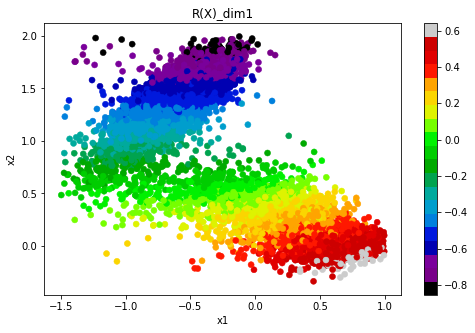

In [220]:
# R = R_net(X0.to(device))
# plt.plot(X0_bar.cpu().detach().numpy()[:, 0], R.cpu().detach().numpy()[:, 0], 'o')

fig, ax = plt.subplots(figsize=(8, 5))
Rd1 = ax.scatter(y0[:,0], y0[:,1], marker='o',lw = 0.5, c = R[:,0], cmap = plt.cm.get_cmap('nipy_spectral', 20))
ax.set_title('R(X)_dim1')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
fig.colorbar(Rd1)

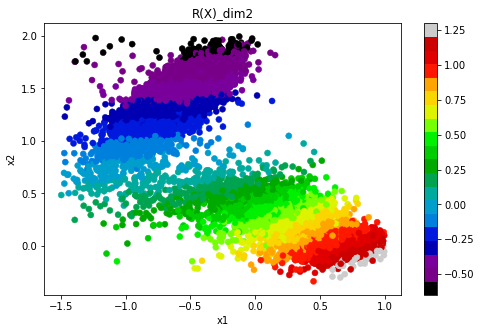

In [221]:
# R = R_net(X0.to(device))
# plt.plot(X0_bar.cpu().detach().numpy()[:, 0], R.cpu().detach().numpy()[:, 0], 'o')

fig, ax = plt.subplots(figsize=(8, 5))
Rd2 = ax.scatter(y0[:,0], y0[:,1], marker='o',lw = 0.5, c = R[:,1], cmap = plt.cm.get_cmap('nipy_spectral', 20))
ax.set_title('R(X)_dim2')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
fig.colorbar(Rd2)